# Sparse Identification of nonlinear dynamics (SINDy)

Previous presentation: Given a differential equation (DE) and initial value, calculate the dynamic \
Now: Given dynamical data, reconstruct the governing DE

This is a hard problem! \
Many physicists devote(d) their lives to finding mathematical descriptions for observed dynamics

<img src="images/physicists.png" width="500"/>

## Mathematical Problem Formulation

Let $x(t) \in \mathbb{R}^n$ the state vector of a physical system at time $t$ \
Simplest case: System obeys ordinary linear DE of first order: \
$\dot x(t) = \xi \cdot x(t)$ for some $\xi \in \mathbb{R}^{n\times n}$ \
Given: Observations of $x$ over time \
Goal: Find $\xi$

## Basic Idea: Linear Regression!

- Numerically calculate $\dot x$ (or measure it)
- Fit $\xi$ with linear regression

### Example: 2D linear system
$\dot x_0 = -0.3x_0 + x_1$ \
$\dot x_1 = -1.2x_0$

$x(t=0) = \begin{pmatrix} 2\\0\end{pmatrix}$

Trajectory using scipy.integrate.solve_ivp:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import sklearn
import pandas as pd
import itertools 

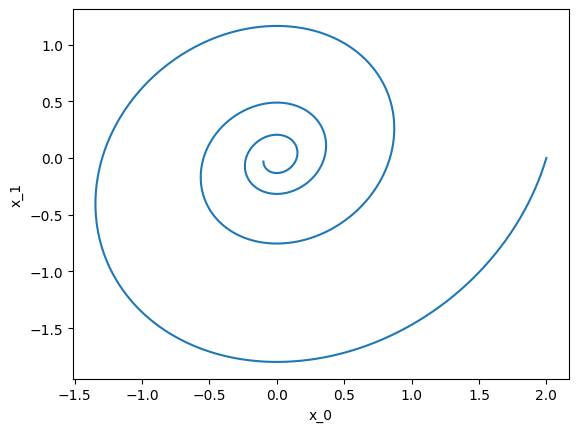

In [2]:
A = np.array([[-0.3, 1],[-1.2, 0.]])
rhs = lambda t,x: np.dot(A,x)

time_interval = [0, 20]
initial_value = [2, 0]

def calc_and_plot_trajectory(rhs, time_interval, initial_value, label=None, plot_over_time=False):
    solution = scipy.integrate.solve_ivp(rhs, time_interval, initial_value, dense_output=True, max_step=0.01)
    t = solution.t
    x = solution.y.T
    
    plt.plot(x[:,0], x[:,1], label=label)
    plt.xlabel("x_0")
    plt.ylabel("x_1")
    if label != None:
        plt.legend()
    if not plot_over_time:
        return t, x
    plt.show()
    plt.plot(t, x[:,0], label="x_0")
    plt.plot(t, x[:,1], label="x_1")
    plt.xlabel("t")
    plt.legend()
    return t, x

t, x = calc_and_plot_trajectory(rhs, time_interval, initial_value, plot_over_time=False)


### Numerical Differentiation
using finite difference method

In [3]:
def numerical_differentiation(t, x, order=1):
    """
    Computes an (N,D*order) array containing the numerical derivatives of x
    """
    N, D = x.shape
    result = np.zeros((N, D*order))
    for i in range(D):
        for o in range(order):
            result[:,order*i+o] = np.gradient(x[:,i], t) if o==0 else np.gradient(result[:,order*i+o-1], t)
    return result

diff_x = numerical_differentiation(t, x, order=1)

[[-0.3  1. ]
 [-1.2  0. ]]


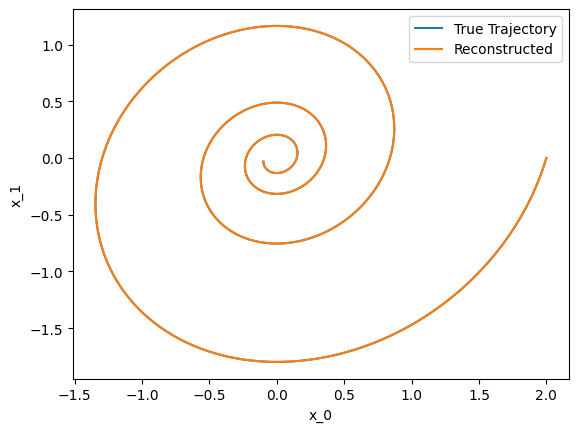

In [4]:
from sklearn import linear_model

reg = linear_model.LinearRegression(fit_intercept=False)

N = x.shape[0]
reg.fit(x, diff_x.reshape((N,-1)))
weights = reg.coef_

print(np.round(weights, 3))

numeric_rhs = lambda t,x: np.dot(weights[:,:2],x)
calc_and_plot_trajectory(rhs, time_interval, initial_value, label="True Trajectory")
calc_and_plot_trajectory(numeric_rhs, time_interval, initial_value, label="Reconstructed");


## Higher order derivatives?

...can be transformed to a system of first order equations!

Example: 1D Harmonic Oscillator with linear damping: \
$\ddot x + 2\gamma\omega \dot x + \omega^2x = 0$ \
where $\omega$ is the undamped angular frequency and $\gamma$ depends on the damping strength

This can be rewritten to a system of first order by setting $x_0=x$ and $x_1 = \dot x$: \
$\dot x_0 = x_1$ \
$\dot x_1 = -\omega^2x_0 - 2\gamma\omega x_1$

[[ 0.    1.  ]
 [-2.25 -0.3 ]]


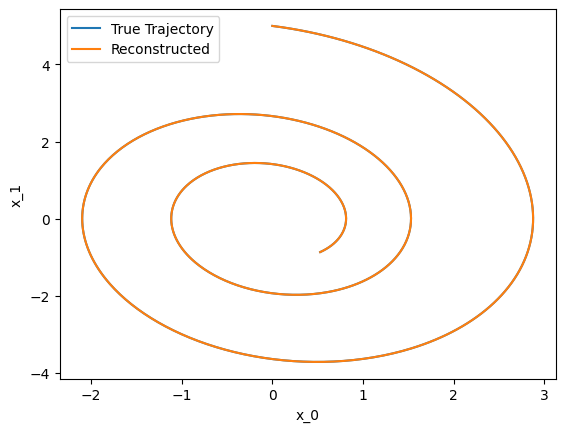

In [5]:
omega = 1.5   # Angular frequency
gamma = 0.1 # Friction coefficient

rhs = lambda t,x: [x[1], -omega**2*x[0] -2*omega*gamma*x[1]]

time_interval = [0, 10]
initial_value = [0, 5]

t, x = calc_and_plot_trajectory(rhs, time_interval, initial_value, label="True Trajectory")
diff_x = numerical_differentiation(t, x, order=1)

reg = linear_model.LinearRegression(fit_intercept=False)
N = x.shape[0]
reg.fit(x, diff_x.reshape((N,-1)))
weights = reg.coef_
print(np.round(weights, 3))

numerical_rhs = lambda t,x: weights @ x
calc_and_plot_trajectory(numerical_rhs, time_interval, initial_value, label="Reconstructed")
plt.show()

## Nonlinear and time-dependent DE's?

### Library of candidate functions

Create a library of nonlinear candidate terms: \
$\Theta: x,t \mapsto \Theta(x,t) \in \mathbb{R}^d$ \
(For example quadratic or trigonometric terms of x and t) \
such that $\dot x(t) = \xi\cdot \Theta(X,t)\,,\; \xi \in \mathbb{R}^{n\times d}$

In [6]:
class BaseLibrary:

    def __init__(self, data, names=None):
        if isinstance(data, pd.DataFrame):
            self.data = data
            return
        if len(data.shape) == 1:
            data = data[:,np.newaxis]
        N, d = data.shape
        if names is None:
            names = [f"x_{i}" for i in range(data.shape[1])]
        assert len(names) == d
        self.data = pd.DataFrame({names[i]: data[:,i] for i in range(d)})
        
    def __add__(self, other):
        new_data = self.data.join(other.data, rsuffix="DROP").filter(regex="^(?!.*DROP)")
        return BaseLibrary(new_data)

    def __str__(self):
        return self.data.__str__()

class PolynomialLibrary(BaseLibrary):

    def __init__(self, library, order=2):
        data = library.data
        names = data.columns
        for i in range(2, order+1):
            combinations = list(itertools.combinations_with_replacement(names, i))
            for combination in combinations:
                values = np.prod([data[element] for element in combination], axis=0)
                
                elements, counts = np.unique(combination, return_counts=True)
                factor_names = [element if count==1 else f"{element}^{count}" for element, count in zip(elements, counts)]
                new_name = "*".join(factor_names)

                data[new_name] = values
        self.data = data

class ConstantLibrary(BaseLibrary):

    def __init__(self, N):
        self.data = pd.DataFrame()
        self.data["1"] = np.ones(N)

class FunctionLibrary(BaseLibrary):

    def __init__(self, library, func, rename_func):
        
        self.data = library.data.map(func)
        self.data.rename(columns=rename_func, inplace=True)

class SinAndCosLibrary(BaseLibrary):

    def __init__(self, library):
        sin = FunctionLibrary(library, np.sin, lambda s: "sin("+s+")")
        cos = FunctionLibrary(library, np.cos, lambda s: "cos("+s+")")
        self.data =  (sin + cos).data


### Synthetic nonlinear example

$\dot x_0 = 1.9\sqrt{x_0} + 2\cos(x_1)$ \
$\dot x_1 = 0.1x_0^2 - 5.4t$ \
$x(t=0) = \begin{pmatrix} 0\\0\end{pmatrix}$

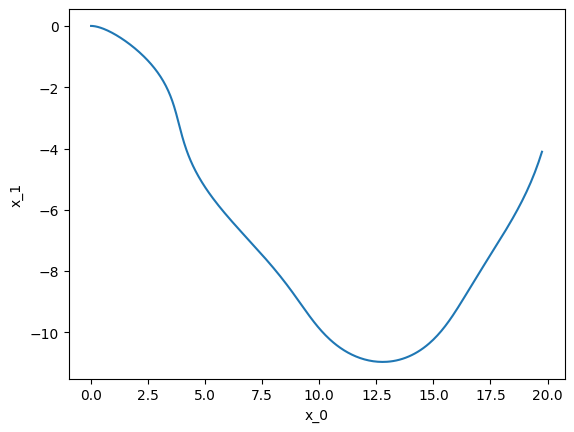

In [7]:
rhs = lambda t,x: [1.9*np.sqrt(x[0]) + 2.*np.cos(x[1]), 0.1*x[0]**2 - 5.4*t]
time_interval = [0, 4]
initial_value = [0., 0.]
t, x = calc_and_plot_trajectory(rhs, time_interval, initial_value)
plt.show()

Library:  ['x', 'y', 'x^2', 'x*y', 'y^2', '1', 'sqrt(x)', 'sin(x)', 'sin(y)', 'cos(x)', 'cos(y)', 't']
Weights:  [[-3.600e-02  2.500e-02  0.000e+00  1.000e-03  2.000e-03  8.000e-03
   1.848e+00  1.000e-02 -1.100e-02 -1.000e-03  1.997e+00  2.570e-01]
 [ 1.800e-02 -1.600e-02  1.000e-01 -1.000e-03 -1.000e-03 -6.000e-03
   3.600e-02 -7.000e-03  6.000e-03  1.000e-03  2.000e-03 -5.556e+00]]
Active terms:  24


/home/luigin/Documents/Computer/standard-venv/lib/python3.13/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in sqrt
  return lib.map_infer(values, mapper, convert=convert)


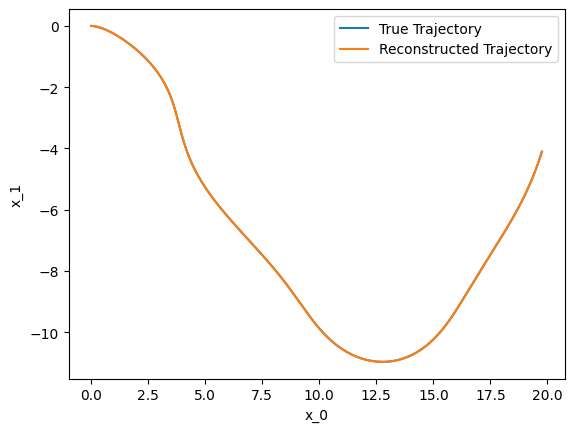

In [8]:
diff_x = numerical_differentiation(t, x)

# Library Construction
time = BaseLibrary(t, names=["t"])
base = BaseLibrary(x, names=["x", "y"])
root = FunctionLibrary(base, np.sqrt, lambda s: "sqrt("+s+")")
trig = SinAndCosLibrary(base)
library = PolynomialLibrary(base, order=2) + ConstantLibrary(len(t)) + root + trig + time
library.data.drop("sqrt(y)", axis=1, inplace=True)
print("Library: ", list(library.data.columns))

reg = linear_model.LinearRegression(fit_intercept=False)
N = x.shape[0]
reg.fit(library.data, diff_x.reshape((N,-1)))
weights = reg.coef_
print("Weights: ", np.round(weights, 3))
print("Active terms: ", (weights != 0).sum())

reconstructed_rhs = lambda t,x: np.dot(weights,[x[0],x[1],x[0]**2,x[0]*x[1],x[1]**2, 1, np.sqrt(x[0]), np.sin(x[0]), np.sin(x[1]), np.cos(x[0]), np.cos(x[1]), t])
calc_and_plot_trajectory(rhs, time_interval, initial_value, label="True Trajectory")
calc_and_plot_trajectory(reconstructed_rhs, time_interval, initial_value, label="Reconstructed Trajectory")
plt.show()

The trajectory is reconstructed well.
**But:** The reconstructed DE is highly complex!
$\dot x = -0.0364x+0.025y+0.000186x^2+0.000661xy+0.00178y^2+0.00816+1.85\sqrt{x}+0.00986\sin(x)-0.0107\sin(y)-0.00129\cos(x)+2\cos(y) + 0.257t$ \
$\dot y = -0.0185x-0.00164y+0.01x^2-0.000507xy-0.0117y^2-0.00627+0.0365\sqrt{x}-0.00673\sin(x)-0.00563\sin(y)+0.000589\cos(x)+0.00163\cos(y) -5.56t$

Solution should be *parsimonous*: \
As easy as possible while still accurate

=> Need Regularization! \
Obvious choice: Lasso Regression \
Induces sparse solution

Weights:  [[ 1.003e+00 -0.000e+00 -2.500e-02  1.500e-02 -3.000e-03  0.000e+00
   0.000e+00  0.000e+00 -0.000e+00  0.000e+00  1.273e+00  0.000e+00]
 [-1.542e+00  6.000e-02  1.230e-01 -1.000e-03 -0.000e+00 -0.000e+00
  -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00]]
Active terms:  9


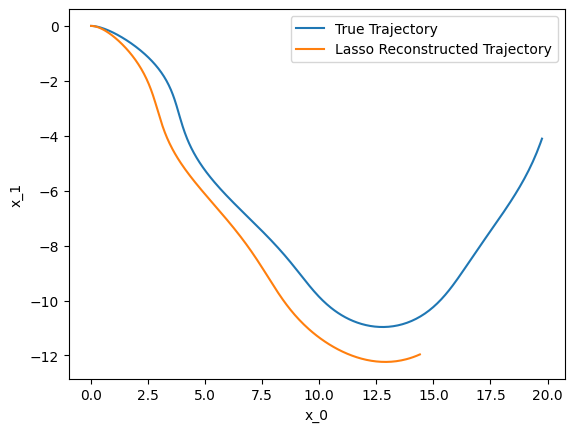

In [9]:
alpha= 0.4
reg = linear_model.Lasso(alpha=alpha, max_iter=10000, fit_intercept=False)
N = x.shape[0]
reg.fit(library.data, diff_x.reshape((N,-1)))
weights = reg.coef_
print("Weights: ", np.round(weights, 3))
print("Active terms: ", (weights != 0).sum())

reconstructed_rhs = lambda t,x: np.dot(weights,[x[0],x[1],x[0]**2,x[0]*x[1],x[1]**2, 1, np.sqrt(x[0]), np.sin(x[0]), np.sin(x[1]), np.cos(x[0]), np.cos(x[1]), t])
calc_and_plot_trajectory(rhs, time_interval, initial_value, label="True Trajectory")
calc_and_plot_trajectory(reconstructed_rhs, time_interval, initial_value, label="Lasso Reconstructed Trajectory")
plt.show()

## Alternative: Sequential Threshold Least Squares (STLSQ)

Idea: Do unregularized linear regression and drop all candidate terms below some threshold (hyperparameter). \
Repeat regression with the leftover terms until convergence.

In [10]:
threshold = 0.04
max_iter = 10

def stlsq(library, Y):
    weights = []
    x = library.to_numpy()
    for y in Y.T:
        weights.append(stlsq_1d(x, y))
    return np.array(weights)

def stlsq_1d(x, y):
    included_terms = np.arange(x.shape[1])
    for _ in range(max_iter):
        w = np.linalg.lstsq(x[:,included_terms], y, rcond=None)[0]
        keep = np.abs(w) > threshold
        if keep.all():
            # Nothing thresholded -> convergence reached
            break
        included_terms = included_terms[keep]
    res = np.zeros(x.shape[1])
    indices = included_terms
    np.put(res, indices, w)
    return res

Terms:  ['x', 'y', 'x^2', 'x*y', 'y^2', '1', 'sqrt(x)', 'sin(x)', 'sin(y)', 'cos(x)', 'cos(y)', 't']
Weights:  [[-2.000e-03  1.000e-03  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   1.900e+00  2.000e-03  0.000e+00  4.000e-03  1.994e+00  1.000e-02]
 [-1.200e-02 -4.000e-03  1.000e-01  0.000e+00  0.000e+00 -3.000e-03
   1.600e-02 -2.000e-03 -3.000e-03  0.000e+00  0.000e+00 -5.401e+00]]
Active terms:  15


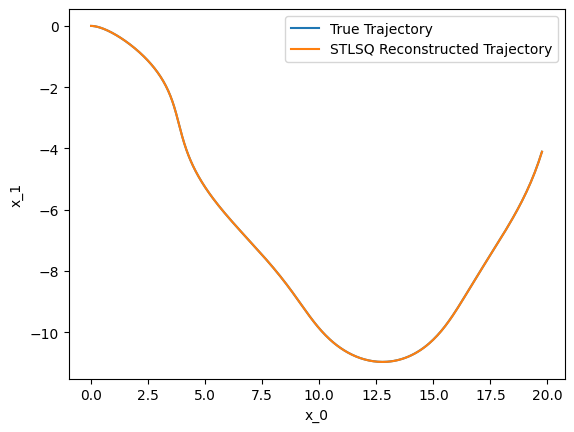

In [11]:
threshold = 0.001
weights = stlsq(library.data, diff_x)
print("Terms: ", list(library.data.columns))
print("Weights: ", np.round(weights, 3))
print("Active terms: ", (weights != 0).sum())

reconstructed_rhs = lambda t,x: np.dot(weights,[x[0],x[1],x[0]**2,x[0]*x[1],x[1]**2, 1, np.sqrt(x[0]), np.sin(x[0]), np.sin(x[1]), np.cos(x[0]), np.cos(x[1]), t])
calc_and_plot_trajectory(rhs, time_interval, initial_value, label="True Trajectory")
calc_and_plot_trajectory(reconstructed_rhs, time_interval, initial_value, label="STLSQ Reconstructed Trajectory")
plt.show()

Setting the threshold accordingly yields a parsimonous solution. \
=> STLSQ is able to reconstruct the DE

Addititonal Advantage: Computationally less expensive than Lasso

There is a tradeoff between sparsity and accuracy of a solution. \
The best solution can be found by tuning the threshold

In [12]:
thresholds = np.logspace(-3,1, 40)
_, true_x = calc_and_plot_trajectory(rhs, time_interval, initial_value)
deviations = []
num_coeffs = []
for threshold in thresholds:
    weights = stlsq(library.data, diff_x)
    num_coeffs.append((weights != 0).sum())

    reconstructed_rhs = lambda t,x: np.dot(weights,[x[0],x[1],x[0]**2,x[0]*x[1],x[1]**2, 1, np.sqrt(x[0]), np.sin(x[0]), np.sin(x[1]), np.cos(x[0]), np.cos(x[1]), t])
    _, re_x = calc_and_plot_trajectory(reconstructed_rhs, time_interval, initial_value)
    error = np.mean(np.sum((true_x-re_x[:404])**2, axis=1))
    deviations.append(error)

plt.close()

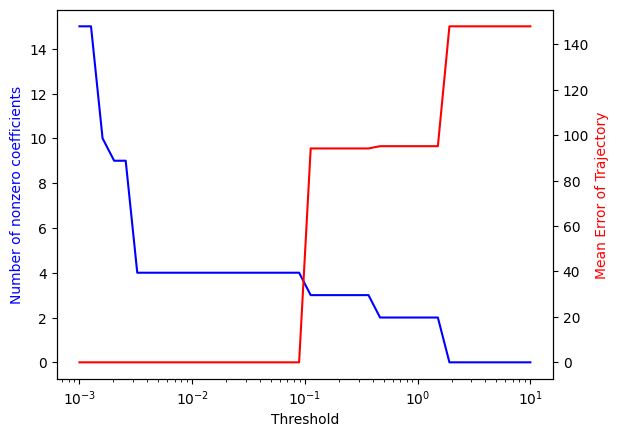

In [13]:
ax = plt.subplot()
ax.set_xlabel("Threshold")
ax.set_xscale("log")
ax.plot(thresholds, num_coeffs, color="blue")
ax.set_ylabel("Number of nonzero coefficients")
ax.yaxis.label.set_color('blue')
ax = ax.twinx()
ax.plot(thresholds, deviations, color="red")
ax.set_ylabel("Mean Error of Trajectory")
ax.yaxis.label.set_color('red')
plt.show()

## Example: Lorenz System
Describes heat convection in the atmosphere \
$\dot x = 10(y-x)$ \
$\dot y = x(28-z)-y$ \
$\dot z = xy-\frac{8}{3}z$

$\begin{pmatrix} x\\y\\z\end{pmatrix}(t=0) = \begin{pmatrix} -8\\7\\27\end{pmatrix}$

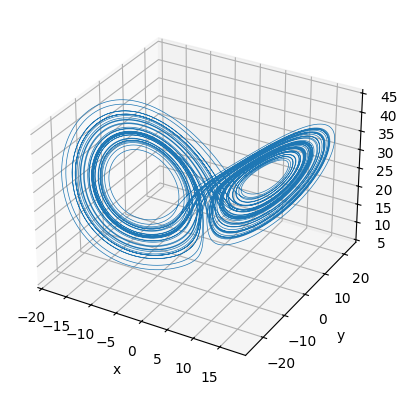

In [14]:
rhs = lambda t,x: [-10*x[0] + 10*x[1], 28*x[0] -x[0]*x[2] -x[1], x[0]*x[1]-8/3.*x[2]]
time_interval = [0, 60]
initial_value = [-8, 7, 27]

def plot_3d(ax, rhs, time_interval, initial_value):  
    solution = scipy.integrate.solve_ivp(rhs, time_interval, initial_value, dense_output=True, max_step=0.001)
    t = solution.t
    x = solution.y.T
    
    ax.plot(*x.T, lw=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return t, x
    
ax = plt.figure().add_subplot(projection='3d')
t,x = plot_3d(ax, rhs, time_interval, initial_value)
plt.show()

Terms:  ['x', 'y', 'z', 'x^2', 'x*y', 'x*z', 'y^2', 'y*z', 'z^2']
Weights:  [[-9.997 10.002  0.     0.     0.     0.     0.     0.     0.   ]
 [27.989 -0.997  0.     0.     0.    -1.     0.     0.     0.   ]
 [ 0.     0.    -2.671  0.     1.001  0.     0.     0.     0.   ]]
Active terms:  7


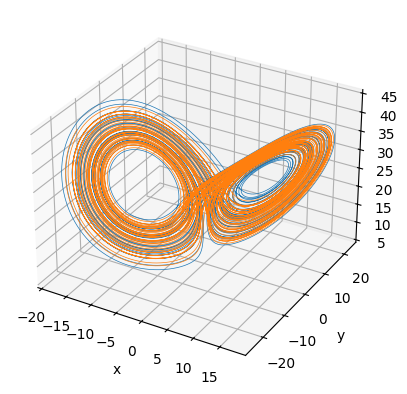

In [20]:
rng = np.random.default_rng(seed=42536714678)
diff_x = numerical_differentiation(t, x)
#print(diff_x.mean())
#print(diff_x.max())
y = diff_x + rng.normal(loc=0, scale=10, size=diff_x.shape)
# Library Construction
base = BaseLibrary(x, names=["x", "y", "z"])
library = PolynomialLibrary(base, order=2)
print("Terms: ", list(library.data.columns))

threshold = 0.01
weights = stlsq(library.data, y)
print("Weights: ", np.round(weights, 3))
print("Active terms: ", (weights != 0).sum())

reconstructed_rhs = lambda t,x: np.dot(weights,[x[0],x[1], x[2], x[0]**2,x[0]*x[1], x[0]*x[2], x[1]**2, x[1]*x[2], x[2]**2])
ax = plt.figure().add_subplot(projection='3d')
plot_3d(ax, rhs, time_interval, initial_value)
plot_3d(ax, reconstructed_rhs, time_interval, initial_value)
plt.show()

## What about PDE's?
    
Partial differential equations have more than one partial derivative per equation \
Example: Navier-Stokes Equation for fluid flow

=> Include partial derivatives in the library

Require more datapoints due to spatial resolution of data \
=> Can use subsampling

<img src="images/pde.png" width="400"/>


## Summary
SINDy is a computational method to find DEs from observed data

Compared to Neural Networks:
- Manual feature engineering necessary (Library)
- High interpretability (directly produces equations)
- Very computationally efficient

Can balance complexity and accuracy of the model by hyperparameter tuning \
Generalization to PDE's not straight-forward

# References
- Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. Discovering Governing
Equations from Data: Sparse Identification of Nonlinear Dynamical Systems. Sept. 2015. doi: 10.48550/arXiv.1509.03580.
- Samuel H. Rudy, Steven L. Brunton, Joshua L. Proctor, J. Nathan Kutz. Data-driven discovery of partial differential equations. 2017. doi:10.1126/sciadv.1602614


## Images:
- https://commons.wikimedia.org/wiki/Isaac_Newton#/media/File:Portrait_of_Sir_Isaac_Newton,_1689.jpg
- https://commons.wikimedia.org/wiki/James_Clerk_Maxwell#/media/File:James-Clerk-Maxwell-1831-1879.jpg
- https://commons.wikimedia.org/wiki/File:Erwin_Schr%C3%B6dinger_(1933).jpg